# Generic programming

From [Wikipedia](https://en.wikipedia.org/wiki/Generic_programming):
> **Generic programming** is a style of computer programming in which algorithms are written in terms of types *to-be-specified-later* that are then *instantiated* when needed for specific types provided as parameters.

# Example: Vandermonde matrix (revisited)

[Vandermonde matrix:](https://en.wikipedia.org/wiki/Vandermonde_matrix)
\begin{align}V=\begin{bmatrix}1&\alpha _{1}&\alpha _{1}^{2}&\dots &\alpha _{1}^{n-1}\\1&\alpha _{2}&\alpha _{2}^{2}&\dots &\alpha _{2}^{n-1}\\1&\alpha _{3}&\alpha _{3}^{2}&\dots &\alpha _{3}^{n-1}\\\vdots &\vdots &\vdots &\ddots &\vdots \\1&\alpha _{m}&\alpha _{m}^{2}&\dots &\alpha _{m}^{n-1}\end{bmatrix}\end{align}

In [ ]:
function vander_naive(x::Vector)
    m = length(x)
    V = Matrix{Float64}(undef, m, m)
    for j = 1:m
        V[j,1] = 1.0
    end
    for i= 2:m
        for j = 1:m
            V[j,i] = x[j] * V[j,i-1]
            end
        end
    return V
end

In [ ]:
vander_naive(rand(3))

In [ ]:
vander_naive(1:3)

In [ ]:
vander_naive([1,2,3])

Why is the result a matrix of floating point numbers....?

Even worse:

In [ ]:
vander_naive(rand(ComplexF64, 3))

* Keep function argument types generic if possible
* Avoid explicit typing if possible

In [ ]:
function vander_generic(x::AbstractVector{T}) where T
    m = length(x)
    V = Matrix{T}(undef, m, m)
    for j = 1:m
        V[j,1] = one(x[j])
    end
    for i= 2:m
        for j = 1:m
            V[j,i] = x[j] * V[j,i-1]
            end
        end
    return V
end

In [ ]:
vander_generic([3, "Stadt", 4 + 5im])

### And all of this comes at no performance penality

In [ ]:
using BenchmarkTools

In [ ]:
x = rand(Float64, 100);
@btime vander_naive($x);
@btime vander_generic($x);

Actually, for this specific example **our generic code is faster** in a few cases inasmuch as type conversions are unnecessary.

In [ ]:
x = rand(Int, 100);
@btime vander_naive($x);
@btime vander_generic($x);

In [ ]:
x = rand(Bool, 100);
@btime vander_naive($x);
@btime vander_generic($x);

On the other hand, sometimes it is worth converting to a different type to dispatch to a faster method or to utilize magic like compiler optimizations.

In [ ]:
x = rand(Float32, 100);
@btime vander_naive($x);
@btime vander_generic($x);

# Generic Programming + Multiple Dispatch + JIT

The possibility to write generic algorithms that compile to fast machine code in combination with multiple dispatch leads to an ([unreasonable](https://www.youtube.com/watch?v=kc9HwsxE1OY)) amount of code reuse. This sharing of code comes in two forms:
1. **Sharing generic algorithms** that work for different package-defined types implementing common abstractions.
 * Examples: StatsBase.jl, SortingAlgorithms.jl, GenericLinearAlgebra.jl,
2. **Sharing types** among a wide variety of packages implementing different algorithms;
 * Examples: DataStructures.jl, OrderedCollections.jl, StaticArrays.jl, Colors.jl, Measurements.jl
 * **You can define methods on types after the type is defined!**

 <img src="revdeps.png" alt="drawing" width="800"/>

As of the time of this writing, **804 packages** depend on the data types provided in [DataStructures.jl](https://juliacollections.github.io/DataStructures.jl/latest/).

**851 packages** reuse type implementations in [OrderedCollections.jl](https://github.com/JuliaCollections/OrderedCollections.jl).

**That's about every third package!**

# Let's get a bit more fancy!

In [ ]:
using Interact

In [ ]:
@manipulate for n in 1:20
    [i*j for i in 1:n, j in 1:n]
end

In [ ]:
function insert_block(A::AbstractMatrix, i, j, what=7)
    B = copy(A)
    B[i:i+2, j:j+2] .= what
    B
end

In [ ]:
A = fill(0, 9, 9)
insert_block(A, 3, 5)  # this returns the new matrix

In [ ]:
A = fill(0, 10, 10)
n = size(A, 1)

@manipulate for i in 1:n-2, j in 1:n-2
    insert_block(A, i, j)
end

### Let's add some color!

Our function `insert_block` is generic. Since the first argument `A isa AbstractArray`, we can index into it and set new values. Pretty much every value type is fine!

In [ ]:
using Colors

In [ ]:
@manipulate for n in 1:80
    distinguishable_colors(n)
end

In [ ]:
colors = distinguishable_colors(10)

In [ ]:
colors[1]

In [ ]:
A = fill(colors[1], 10, 10)
n = size(A, 1)

@manipulate for i in 1:n-2, j in 1:n-2
    insert_block(A, i, j, colors[4])
end

## Emergent features: Example DifferentiaEquations.jl

$$\frac{du}{dt} = f(u,p,t)$$

`Measurement` type from [Measurements.jl]() and differential equation solver from [OrdinaryDiffEq.jl](https://github.com/JuliaDiffEq/OrdinaryDiffEq.jl) (i.e. [DifferentialEquations.jl](https://github.com/JuliaDiffEq/DifferentialEquations.jl))

In [5]:
using OrdinaryDiffEq

#Half-life of Carbon-14 is 5730 years.
c = 5.730

#Setup
u0 = 1.0
tspan = (0.0, 1.0)

#Define the problem
radioactivedecay(u,p,t) = -c*u

#Pass to solver
prob = ODEProblem(radioactivedecay,u0,tspan)

ODEProblem with uType Float64 and tType Float64. In-place: false
timespan: (0.0, 1.0)
u0: 1.0

In [6]:
sol = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8);

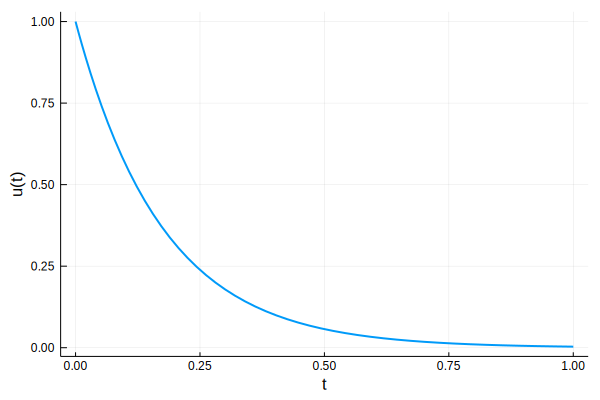

In [24]:
using Plots

plot(sol.t, sol.u, ylabel="u(t)", xlabel="t", lw=2, legend=false)

### Arbitrary precision

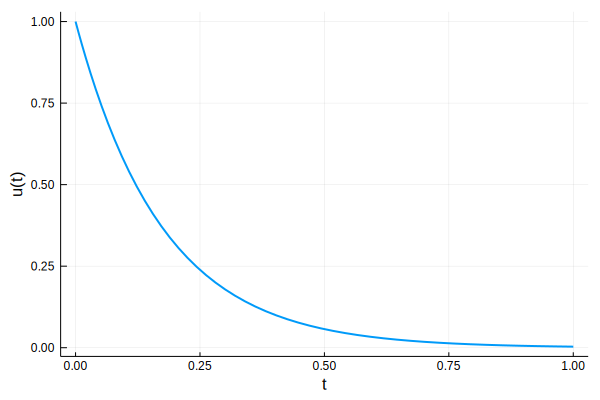

In [25]:
using OrdinaryDiffEq, Measurements, Plots

#Half-life of Carbon-14 is 5730 years.
c = big(5.730) # now a BigFloat

#Setup
u0 = big(1.0) # now a BigFloat
tspan = (0.0, 1.0)

#Define the problem
radioactivedecay(u,p,t) = -c*u

#Pass to solver
prob = ODEProblem(radioactivedecay,u0,tspan)
sol = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8);

plot(sol.t, sol.u, ylabel="u(t)", xlabel="t", lw=2, legend=false)

In [15]:
sol.u

48-element Array{BigFloat,1}:
 1.0                                                                                
 0.9677886860242480802598783250713916010081415505397800881445406271537611300017618  
 0.9315211281525870696951220469884643089015968992100693760200740553948355529147443  
 0.8884024345211743161021160493163086874961411762569637929039406549449358585920417  
 0.8418375252286853526018156034028654546424997684271563776179902463787617679492211  
 0.7919476680197978130129370628972353995826991637831352877688831499482679169139974  
 0.7407016259183958391757039618594165227639572775337525341594247992333817572100918  
 0.6889166236940076080002239132042014361405924597885439675027524004548444995732002  
 0.6377469535070398349649293862161431951718088662130859799205713009042556096647567  
 0.5878693713657286439755737446549580093909012667283176744130450838954131268967931  
 0.5398978652256644388443113633025199796421787288250581423811316455632597496131444  
 0.49420597078315307183358331460464

### With uncertainties: Measurements.jl

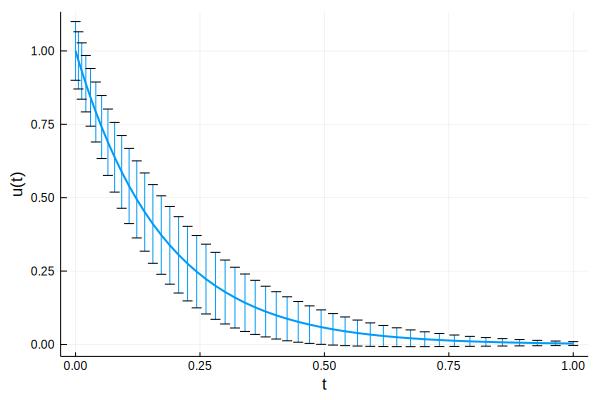

In [26]:
using OrdinaryDiffEq, Measurements, Plots

#Half-life of Carbon-14 is 5730 years.
c = 5.730 ± 2

#Setup
u0 = 1.0 ± 0.1
tspan = (0.0, 1.0)

#Define the problem
radioactivedecay(u,p,t) = -c*u

#Pass to solver
prob = ODEProblem(radioactivedecay,u0,tspan)
sol = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8);

plot(sol.t, sol.u, ylabel="u(t)", xlabel="t", lw=2, legend=false)

Note that, in some sense, **Julia implemented that feature by itself**.

The authors of Measurements.jl and DifferentialEquations.jl never had any collabration on this.

It **just works**.

# Core messages of this Notebook

* It is simple to write **type-generic code** in Julia and you should do it.
* Generally, **generic code is just as fast as specific code**.
* Generic Programming + Multiple Dispatch + JIT = **lots of code sharing and emergent features**